<a href="https://colab.research.google.com/github/yetinam/pyocto/blob/examples/03_interfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/yetinam/pyocto/main/docs/_static/pyocto_logo_outlined.svg)

*This code is necessary on colab to install PyOcto. If PyOcto is already installed on your machine, you can skip this. We will use this library for picking phase arrivals.*

In [ ]:
!pip install pyocto seisbench

# Interfaces

PyOcto comes with a collection of interfaces to different tools and alternative associators. Here, we will show the interfaces to obspy and SeisBench. In addition, PyOcto has interfaces to NonLinLoc, the REAL associator, and the GaMMA associator. All interfaces are detailed in the [PyOcto documentation](https://pyocto.readthedocs.io/en/latest/pages/associator.html).

In [1]:
import pyocto
import matplotlib.pyplot as plt
import seisbench.models as sbm
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from collections import Counter
import torch
import numpy as np

## Obtaining the data

For this tutorial, we will use waveforms from the aftershock sequence of the Iquique earthquake 2014 in Northern Chile. We use half a day of data, starting roughly a day after the mainshock. We download the data and station information through FDSN from GEOFON. This will take up to a few minutes. Reduce the time period if your internet connection is slow.

In [2]:
client = Client("GFZ")

t0 = UTCDateTime("2014/04/03 00:00:00")
t1 = t0 + 12 * 60 * 60
# t1 = t0 + 24 * 60 * 60   # Full day, requires more memory
stream = client.get_waveforms(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)

inv = client.get_stations(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)

We now pick the continouos waveforms using PhaseNet from SeisBench. We use the model pretrained on INSTANCE, as this model shows good performance across regions. We set low picking thresholds, i.e., we expect lots of picks. The picking will take up to a few minutes.

In [3]:
picker = sbm.PhaseNet.from_pretrained("instance")

if torch.cuda.is_available():
    picker.cuda()

# We tuned the thresholds a bit - Feel free to play around with these values
picks = picker.classify(stream, batch_size=256, P_threshold=0.05, S_threshold=0.05).picks

Counter([p.phase for p in picks])  # Output number of P and S picks

2023-10-16 17:10:59,676 | seisbench | WARNING | You are processing a large stream with the sequential asyncio implementation. Consider activating parallelisation. For details, see http://docs.seisbench.org/en/stable/pages/documentation/models.html#seisbench.models.base.WaveformModel.annotate


Counter({'P': 9730, 'S': 5885})

## Creating the associator

Let's create the associator. This step works exactly as in the examples before. For simplicity, we use a homogeneous velocity model.

In [4]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
    association_cutoff_distance=250,
)

associator = pyocto.OctoAssociator.from_area(
    lat=(-25, -18),
    lon=(-71.5, -68),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
)

## The obspy interface

The first interface we use, connects obspy inventories to PyOcto station dataframes. If defined, it automatically applies the local coordinate transformation.

In [5]:
stations = associator.inventory_to_df(inv)
stations

,id,longitude,latitude,elevation,x,y,z
0,CX.PB01.,-69.48740,-21.043230,900.0,27.294830,50.551380,-0.900
1,CX.PB02.,-69.89603,-21.319730,1015.0,-15.150241,19.952907,-1.015
2,CX.PB03.,-69.75310,-22.048470,1460.0,-0.320004,-60.730576,-1.460
3,CX.PB04.,-70.14918,-22.333690,1520.0,-41.123292,-92.368236,-1.520
4,CX.PB05.,-70.20235,-22.852830,1150.0,-46.426533,-149.873692,-1.150
5,CX.PB06.,-69.57188,-22.705800,1440.0,18.300671,-133.531257,-1.440
6,CX.PB07.,-69.88618,-21.726670,1570.0,-14.089037,-25.104255,-1.570
7,CX.PB08.,-69.15340,-20.141120,3060.0,62.377492,150.336222,-3.060
8,CX.PB09.,-69.24192,-21.796380,1530.0,52.540503,-32.903341,-1.530
9,CX.PB10.,-70.55408,-23.513430,250.0,-82.123088,-223.191624,-0.250


## The SeisBench interface

To use the SeisBench interface, we change the call to the associator. Instead of `associate`, we now use `associate_seisbench` and pass a list of SeisBench picks to the model. As we are associating lots of picks, this will take a few seconds to minutes.

In [6]:
events, assignments = associator.associate_seisbench(picks, stations)

Let's inspect and visualize the outputs. In total, we found over 400 events in this 12 hours. This is a credible number in the dense aftershock sequence of a magnitude 8.1 earthquake. Visualizing the events, we find that almost all events locate to the Iquique rupture area offshore Northern Chile.

In [7]:
events

,idx,time,x,y,z,picks
0,0,1.396483e+09,-148.430566,183.168614,3.515625,19
1,1,1.396484e+09,-68.784897,162.702066,26.171875,13
2,2,1.396484e+09,-106.435577,203.635162,1.953125,20
3,3,1.396484e+09,-129.605226,159.669985,30.859375,19
4,4,1.396484e+09,-70.233000,168.008208,24.609375,15
...,...,...,...,...,...,...
423,423,1.396526e+09,-148.430566,158.911965,4.296875,15
424,424,1.396526e+09,-76.025412,95.238260,18.359375,25
425,425,1.396526e+09,-158.567288,201.361101,3.515625,11
426,426,1.396526e+09,-107.883680,155.121863,15.234375,22


Text(0, 0.5, 'Northing [km]')

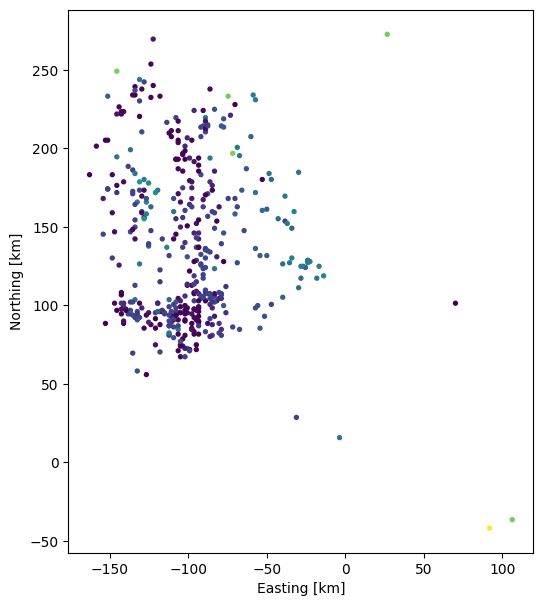

In [8]:
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.scatter(events["x"], events["y"], c=events["z"], s=8)
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")

## Inspecting events

As a last step, let's inspect the waveforms of a few example events. Every time you run the cell, you'll get a different example.

Event information
idx      1.240000e+02
time     1.396497e+09
x       -9.340265e+01
y        1.422355e+02
z        1.210938e+01
picks    1.700000e+01
Name: 124, dtype: float64


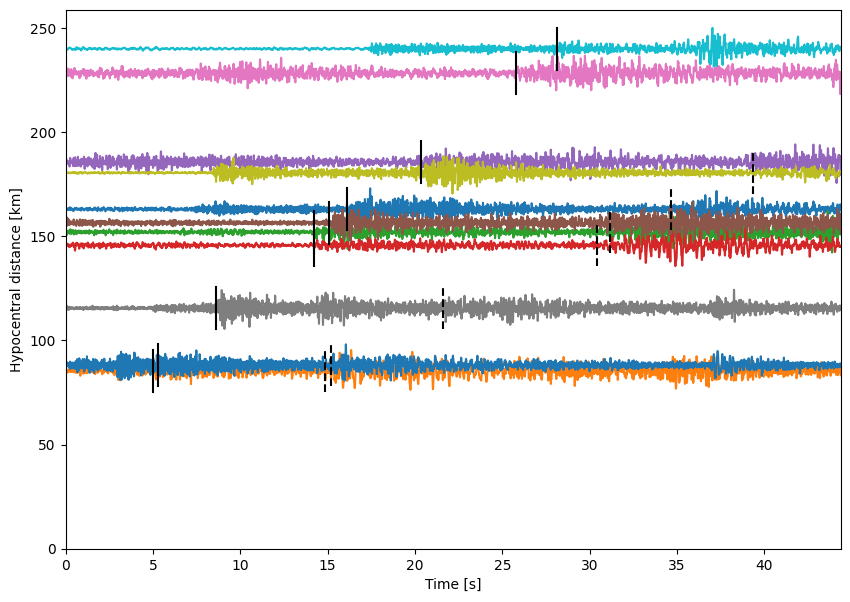

In [9]:
event_idx = np.random.randint(len(events))
event_picks = assignments[assignments["event_idx"] == event_idx]
event = events.iloc[event_idx]

first, last = UTCDateTime(event_picks["time"].min()), UTCDateTime(event_picks["time"].max())

sub = obspy.Stream()

for station in event_picks["station"].unique():
    sub.append(stream.select(station=station[3:-1], channel="HHZ")[0])

sub = sub.slice(first - 5, last + 5)

sub = sub.copy()
sub.detrend()
sub.filter("highpass", freq=2)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

station_dict = {station: (x, y) for station, x, y in zip(stations["id"], stations["x"], stations["y"])}

for i, trace in enumerate(sub):
    normed = trace.data - np.mean(trace.data)
    normed = normed / np.max(np.abs(normed))
    station_x, station_y = station_dict[trace.id[:-4]]
    y = np.sqrt((station_x - event["x"]) ** 2 + (station_y - event["y"]) ** 2 + event["z"] ** 2)
    ax.plot(trace.times(), 10 * normed + y)
    
for _, pick in event_picks.iterrows():
    station_x, station_y = station_dict[pick["station"]]
    y = np.sqrt((station_x - event["x"]) ** 2 + (station_y - event["y"]) ** 2 + event["z"] ** 2)
    x = UTCDateTime(pick["time"]) - trace.stats.starttime
    if pick.phase == "P":
        ls = '-'
    else:
        ls = '--'
    ax.plot([x, x], [y - 10, y + 10], 'k', ls=ls)
    
ax.set_ylim(0)
ax.set_xlim(0, np.max(trace.times()))
ax.set_ylabel("Hypocentral distance [km]")
ax.set_xlabel("Time [s]")

print("Event information")
print(event)